## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [5]:
image_path = []
labels = []

for i in os.listdir("/Users/jay/Jupyter Projects/Hollywood/Hollywood"):
    for label in os.listdir(f"/Users/jay/Jupyter Projects/Hollywood/Hollywood/{i}"):
        for image in os.listdir(f"/Users/jay/Jupyter Projects/Hollywood/Hollywood/{i}"):
            image_path.append(f"/Users/jay/Jupyter Projects/Hollywood/Hollywood/{i}/{image}")
            labels.append(i)

df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

,image_path,labels
0,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Robert Downey Jr
1,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Robert Downey Jr
2,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Robert Downey Jr
3,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Robert Downey Jr
4,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Robert Downey Jr
...,...,...
1795,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Megan Fox
1796,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Megan Fox
1797,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Megan Fox
1798,/Users/jay/Jupyter Projects/Hollywood/Hollywoo...,Megan Fox


## Statistical Modeling ##

Shape:  (1800, 2)

Counts:
 labels
Scarlett Johansson    200
Robert Downey Jr      100
Denzel Washington     100
Sandra Bullock        100
Nicole Kidman         100
Natalie Portman       100
Will Smith            100
Kate Winslet          100
Tom Hanks             100
Brad Pitt             100
Johnny Depp           100
Angelina Jolie        100
Hugh Jackman          100
Tom Cruise            100
Jennifer Lawrence     100
Leonardo DiCaprio     100
Megan Fox             100
Name: count, dtype: int64



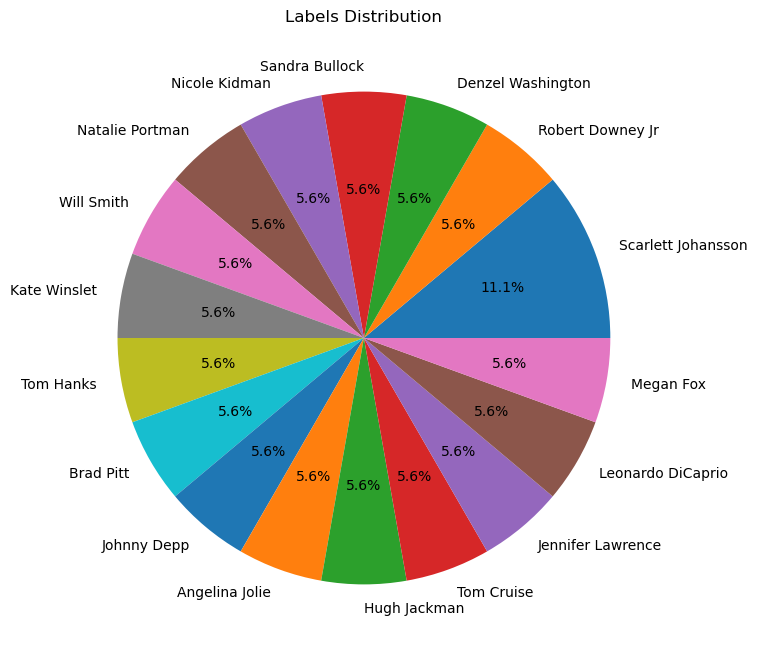

In [7]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["labels"].value_counts(), labels = df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

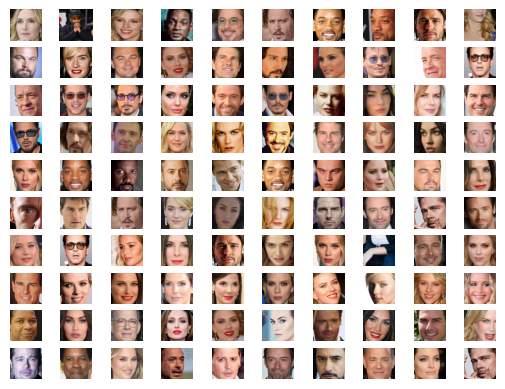

In [9]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()

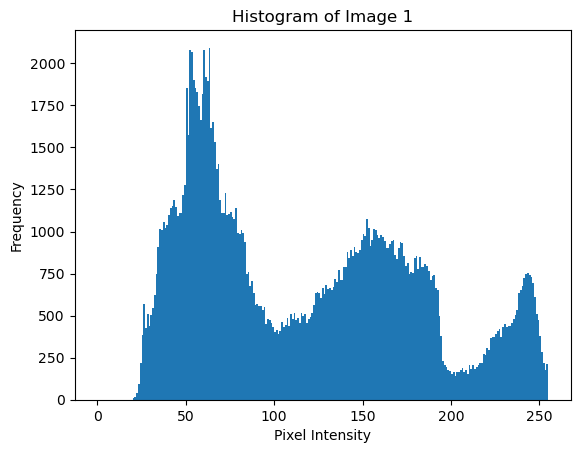

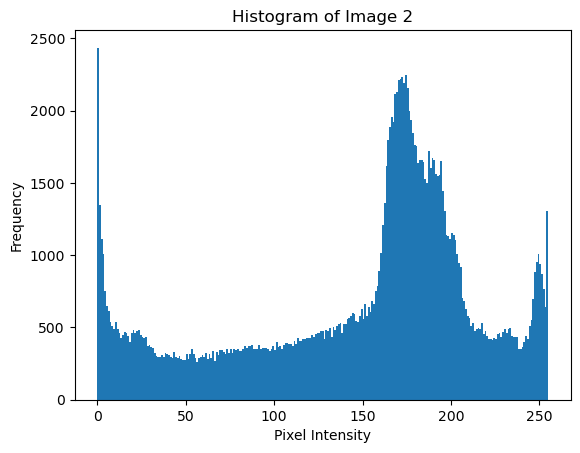

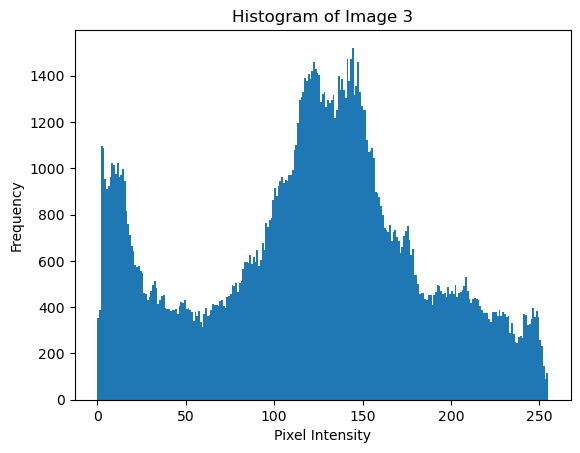

In [11]:
for i in range(0, 3):
    plt.figure()
    
    img_data = np.array(Image.open(df.iloc[i, 0])).ravel()
    
    plt.hist(img_data, bins=range(256))
    
    plt.title(f"Histogram of Image {i+1}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.show()

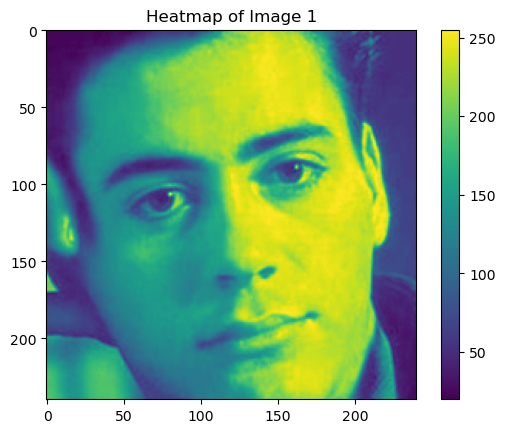

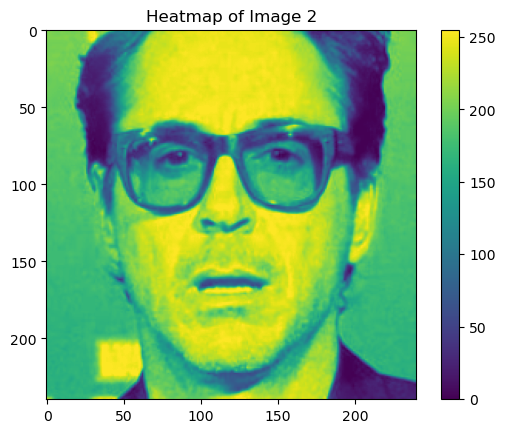

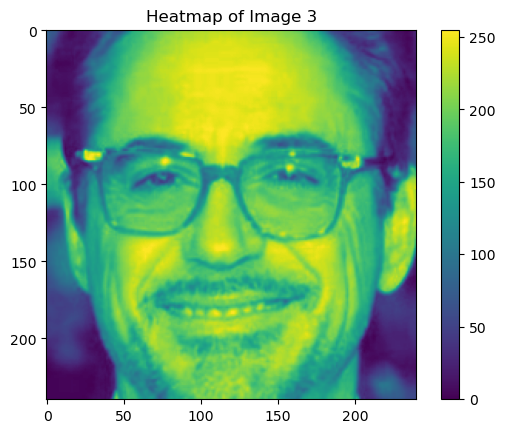

In [13]:
for i in range(0, 3):
    plt.figure()

    img_data = np.array(Image.open(df.iloc[i, 0]))

    cax = plt.imshow(img_data, cmap="viridis", interpolation="nearest")

    plt.title(f"Heatmap of Image {i+1}")

    plt.colorbar(cax)

    plt.imshow(img_data[:, :, 0])

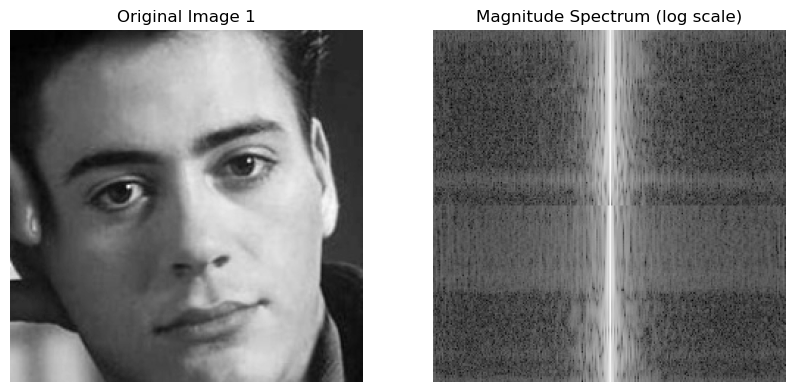

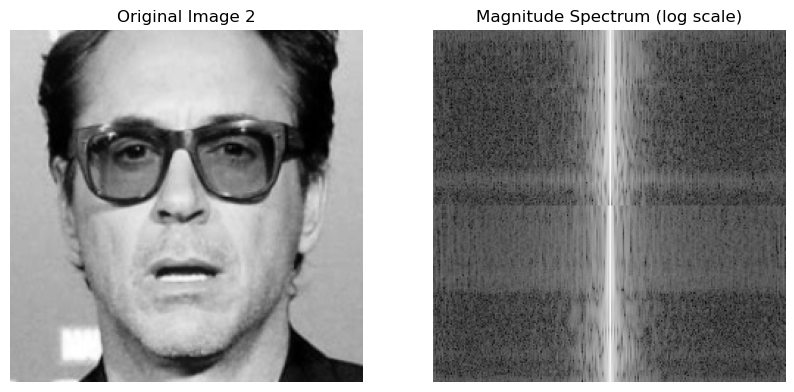

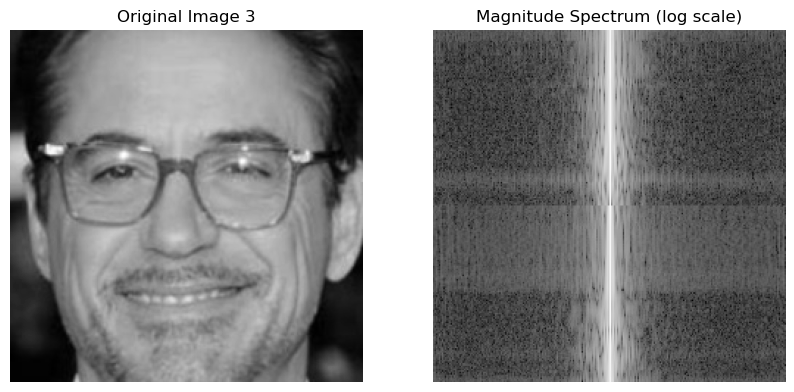

In [15]:
for i in range(0, 3):
    img_data = plt.imread(df.iloc[0+i, 0])
    
    if len(img_data.shape) == 3:
        img_data = np.mean(img_data, axis=2)
    
    ft = np.fft.fft2(image)
    
    ft_shifted = np.fft.fftshift(ft)
    
    magnitude_spectrum = np.abs(ft_shifted)
    
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_data, cmap="gray")
    plt.title(f"Original Image {i+1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum_log[:, :, 0], cmap="gray")
    plt.title("Magnitude Spectrum (log scale)")
    plt.axis("off")
    
    plt.show()

## Training Model ##

In [17]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(1260, 2)
(270, 2)
(270, 2)


In [19]:
le = LabelEncoder()
le.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [23]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

In [392]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 20

In [394]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [396]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 512, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((1024*4*4), 1024)

        self.output = nn.Linear(1024, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16)
        x = self.relu(x)

        x = self.conv4(x) #(512, 16, 16)
        x = self.pooling(x) #(512, 8, 8)
        x = self.relu(x)

        x = self.conv5(x) #(1024, 8, 8)
        x = self.pooling(x) #(1024, 4, 4) same as number in self.linear
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [398]:
model = Net().to(device)

In [400]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            590,336
├─Conv2d: 1-5                            4,719,616
├─MaxPool2d: 1-6                         --
├─ReLU: 1-7                              --
├─Flatten: 1-8                           --
├─Linear: 1-9                            16,778,240
├─Linear: 1-10                           17,425
Total params: 22,198,865
Trainable params: 22,198,865
Non-trainable params: 0

In [402]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [404]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1/20 
    Training Loss: 0.2226 
    Training Accuracy: 10.873 
    Validation Loss: 0.0464 
    Validation Accuracy: 12.5926
Epoch no. 2/20 
    Training Loss: 0.2067 
    Training Accuracy: 17.7778 
    Validation Loss: 0.0418 
    Validation Accuracy: 24.4444
Epoch no. 3/20 
    Training Loss: 0.1879 
    Training Accuracy: 23.8889 
    Validation Loss: 0.0386 
    Validation Accuracy: 32.5926
Epoch no. 4/20 
    Training Loss: 0.1671 
    Training Accuracy: 31.4286 
    Validation Loss: 0.035 
    Validation Accuracy: 34.4444
Epoch no. 5/20 
    Training Loss: 0.1417 
    Training Accuracy: 40.4762 
    Validation Loss: 0.0315 
    Validation Accuracy: 42.963
Epoch no. 6/20 
    Training Loss: 0.1241 
    Training Accuracy: 47.4603 
    Validation Loss: 0.0308 
    Validation Accuracy: 45.9259
Epoch no. 7/20 
    Training Loss: 0.1064 
    Training Accuracy: 57.4603 
    Validation Loss: 0.0292 
    Validation Accuracy: 47.037
Epoch no. 8/20 
    Training Loss: 0.0926 
  

In [408]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 65.1852 
Loss: 0.0464


## Post-Training Analysis ##

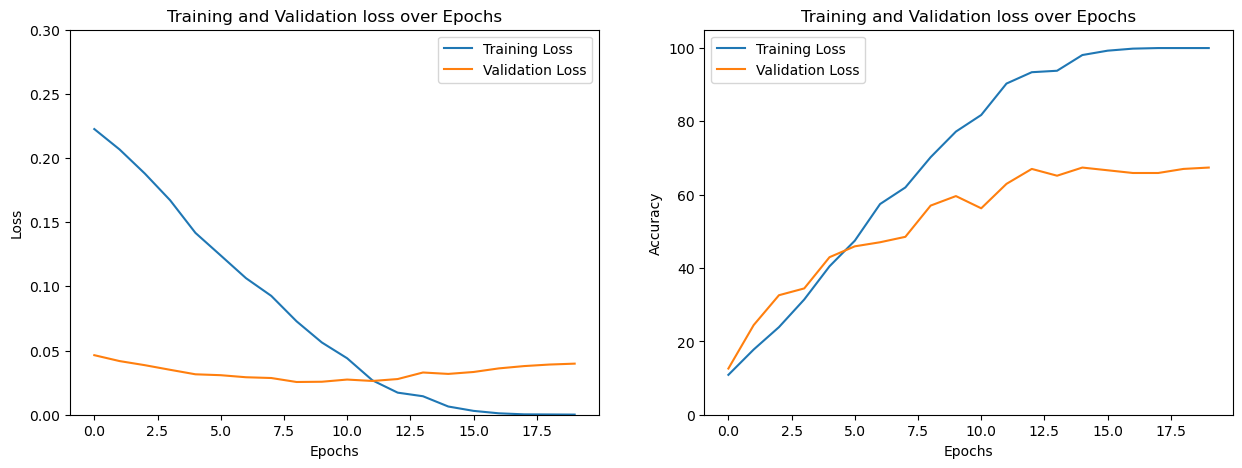

In [422]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.3])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,105])
axs[1].legend()

plt.show()

In [412]:
torch.save(model.state_dict(), "Hollywood.pth")

In [414]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("Hollywood.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=16384, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=17, bias=True)
)

In [416]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['Will Smith']


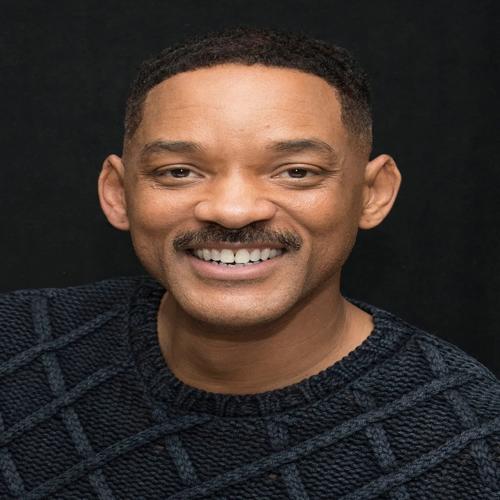

In [418]:
path1 = "/Users/jay/Jupyter Projects/Hollywood/Will.webp"
print(predict_image(path1))
Image.open(path1).convert("RGB").resize([500, 500])

['Denzel Washington']


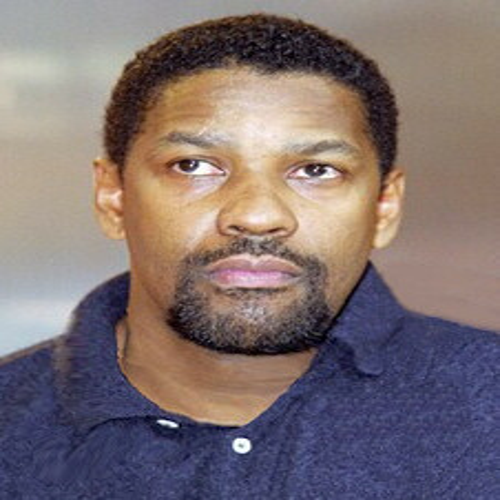

In [420]:
path2 = "/Users/jay/Jupyter Projects/Hollywood/Denzel.jpg"
print(predict_image(path2))
Image.open(path2).convert("RGB").resize([500, 500])